In [2]:
%matplotlib notebook
%matplotlib inline

import os
import time
import datetime as dt
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import pandas 
import pandas_datareader
import stock_data_preprocessing

In [3]:
# load  data

start = dt.datetime(1995,1,1)
end = dt.date.today()
data = pandas_datareader.data.DataReader('GOOG', 'yahoo', start, end)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100


In [4]:
data.index.shape
data.index[:10]

DatetimeIndex(['2004-08-19', '2004-08-20', '2004-08-23', '2004-08-24',
               '2004-08-25', '2004-08-26', '2004-08-27', '2004-08-30',
               '2004-08-31', '2004-09-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [5]:
# normalize data
#data_n = stock_data_preprocessing.normalize_stock_data(data)
data_n = stock_data_preprocessing.normalize_stock_data(data)
data_n.head()

,Ordinal/1e6,Weekday,Adj Volume,Adj Close,Adj Open,Adj High,Adj Low,Normalised Volume,Normalised Close,Normalised Open,Normalised High,Normalised Low
Date,,,,,,,,,,,,
2004-08-19,0.731812,3.0,0.543621,1.000000,0.996611,1.037074,0.956348,0.000000,0.000000,0.000000,0.000000,0.000000
2004-08-20,0.731813,4.0,0.277955,1.079430,1.006677,1.087104,1.001595,-0.722045,0.079430,0.006677,0.087104,0.001595
2004-08-23,0.731816,0.0,0.222225,1.090293,1.103747,1.130955,1.086805,-0.794127,0.010064,0.022528,0.047733,0.006832
2004-08-24,0.731817,1.0,0.185600,1.045146,1.108631,1.112218,1.032190,-0.829771,-0.041408,0.016819,0.020110,-0.053291
2004-08-25,0.731818,2.0,0.111848,1.056408,1.046043,1.076340,1.035280,-0.892983,0.010775,0.000858,0.029847,-0.009440


In [8]:
data_n.shape

(3284, 12)

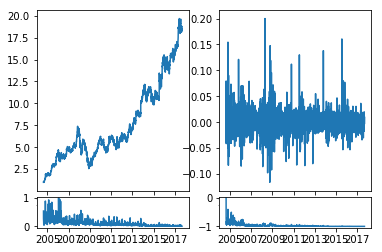

In [28]:
stock_data_preprocessing.stock_plot((data_n,))

In [29]:
# pick up the data
# training data
prediction_time = 1 #day
testdatasize = 450
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1
x_train = data_n[0:-prediction_time-testdatacut].as_matrix()
y_train = data_n[prediction_time:-testdatacut  ]['Normalised Close'].as_matrix()

# test data
x_test = data_n[0-testdatacut:-prediction_time].as_matrix()
y_test = data_n[prediction_time-testdatacut:  ]['Normalised Close'].as_matrix()

In [30]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

print("x_train", len(x_train))


x_train (2782, 12)
y_train (2782,)
x_test (500, 12)
y_test (500,)
x_train 2782


In [31]:
# unroll it
def unroll(data, sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index+sequence_length])
    return np.array(result)

x_train = unroll(x_train, unroll_length)
x_test = unroll(x_test, unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]


print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)
print("x_train", x_train.shape[-1])


x_train (2732, 50, 12)
y_train (2732,)
x_test (450, 50, 12)
y_test (450,)
x_train 12


In [32]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import lstm, time #helper libraries

In [34]:
model = Sequential()

model.add(LSTM(
    input_dim = x_train.shape[-1],
    output_dim = 50,
    return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(
    100, 
    return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim = 1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time:{}'.format(time.time()-start))


compilation time:0.024236202239990234


In [35]:
model.fit(
    x_train,
    y_train,
    batch_size=3028,
    nb_epoch=350,
    validation_split=0.05)

Train on 2595 samples, validate on 137 samples
Epoch 1/350
2595/2595 [==============================] - 5s - loss: 0.1105 - val_loss: 0.4390
Epoch 2/350
2595/2595 [==============================] - 3s - loss: 0.6151 - val_loss: 0.0257
Epoch 3/350
2595/2595 [==============================] - 3s - loss: 0.0190 - val_loss: 0.0044
Epoch 4/350
2595/2595 [==============================] - 3s - loss: 0.0110 - val_loss: 0.0032
Epoch 5/350
2595/2595 [==============================] - 3s - loss: 0.0092 - val_loss: 0.0023
Epoch 6/350
2595/2595 [==============================] - 3s - loss: 0.0092 - val_loss: 0.0015
Epoch 7/350
2595/2595 [==============================] - 3s - loss: 0.0087 - val_loss: 0.0012
Epoch 8/350
2595/2595 [==============================] - 3s - loss: 0.0086 - val_loss: 9.0490e-04
Epoch 9/350
2595/2595 [==============================] - 3s - loss: 0.0079 - val_loss: 6.8269e-04
Epoch 10/350
2595/2595 [==============================] - 3s - loss: 0.0077 - val_loss: 6.4580e-04


2595/2595 [==============================] - 3s - loss: 0.0027 - val_loss: 0.0016
Epoch 87/350
2595/2595 [==============================] - 3s - loss: 0.0027 - val_loss: 0.0029
Epoch 88/350
2595/2595 [==============================] - 3s - loss: 0.0027 - val_loss: 0.0019
Epoch 89/350
2595/2595 [==============================] - 3s - loss: 0.0026 - val_loss: 0.0018
Epoch 90/350
2595/2595 [==============================] - 3s - loss: 0.0023 - val_loss: 0.0012
Epoch 91/350
2595/2595 [==============================] - 3s - loss: 0.0021 - val_loss: 0.0014
Epoch 92/350
2595/2595 [==============================] - 3s - loss: 0.0017 - val_loss: 8.3925e-04
Epoch 93/350
2595/2595 [==============================] - 3s - loss: 0.0015 - val_loss: 9.8356e-04
Epoch 94/350
2595/2595 [==============================] - 3s - loss: 0.0014 - val_loss: 6.9280e-04
Epoch 95/350
2595/2595 [==============================] - 3s - loss: 0.0014 - val_loss: 9.3203e-04
Epoch 96/350
2595/2595 [=======================

2595/2595 [==============================] - 3s - loss: 5.4427e-04 - val_loss: 5.0293e-04
Epoch 168/350
2595/2595 [==============================] - 3s - loss: 4.8909e-04 - val_loss: 4.4665e-04
Epoch 169/350
2595/2595 [==============================] - 3s - loss: 4.7335e-04 - val_loss: 4.5819e-04
Epoch 170/350
2595/2595 [==============================] - 3s - loss: 4.6229e-04 - val_loss: 4.3741e-04
Epoch 171/350
2595/2595 [==============================] - 3s - loss: 4.6255e-04 - val_loss: 4.5466e-04
Epoch 172/350
2595/2595 [==============================] - 3s - loss: 4.5057e-04 - val_loss: 4.3731e-04
Epoch 173/350
2595/2595 [==============================] - 3s - loss: 4.5671e-04 - val_loss: 4.5305e-04
Epoch 174/350
2595/2595 [==============================] - 3s - loss: 4.5125e-04 - val_loss: 4.3629e-04
Epoch 175/350
2595/2595 [==============================] - 3s - loss: 4.4632e-04 - val_loss: 4.5949e-04
Epoch 176/350
2595/2595 [==============================] - 3s - loss: 4.6103e-

2595/2595 [==============================] - 3s - loss: 4.0567e-04 - val_loss: 4.4092e-04
Epoch 246/350
2595/2595 [==============================] - 3s - loss: 4.0033e-04 - val_loss: 4.3919e-04
Epoch 247/350
2595/2595 [==============================] - 3s - loss: 4.0149e-04 - val_loss: 4.4007e-04
Epoch 248/350
2595/2595 [==============================] - 3s - loss: 4.0321e-04 - val_loss: 4.3911e-04
Epoch 249/350
2595/2595 [==============================] - 3s - loss: 4.0406e-04 - val_loss: 4.4289e-04
Epoch 250/350
2595/2595 [==============================] - 3s - loss: 4.0257e-04 - val_loss: 4.3882e-04
Epoch 251/350
2595/2595 [==============================] - 3s - loss: 4.0665e-04 - val_loss: 4.4983e-04
Epoch 252/350
2595/2595 [==============================] - 3s - loss: 4.1310e-04 - val_loss: 4.4254e-04
Epoch 253/350
2595/2595 [==============================] - 3s - loss: 4.3437e-04 - val_loss: 4.8670e-04
Epoch 254/350
2595/2595 [==============================] - 3s - loss: 4.6184e-

2595/2595 [==============================] - 3s - loss: 4.1468e-04 - val_loss: 4.5019e-04
Epoch 324/350
2595/2595 [==============================] - 3s - loss: 4.0997e-04 - val_loss: 4.3996e-04
Epoch 325/350
2595/2595 [==============================] - 3s - loss: 4.0782e-04 - val_loss: 4.4622e-04
Epoch 326/350
2595/2595 [==============================] - 3s - loss: 4.0309e-04 - val_loss: 4.3895e-04
Epoch 327/350
2595/2595 [==============================] - 3s - loss: 4.0314e-04 - val_loss: 4.4402e-04
Epoch 328/350
2595/2595 [==============================] - 3s - loss: 4.0341e-04 - val_loss: 4.3853e-04
Epoch 329/350
2595/2595 [==============================] - 3s - loss: 4.0113e-04 - val_loss: 4.4355e-04
Epoch 330/350
2595/2595 [==============================] - 3s - loss: 4.0005e-04 - val_loss: 4.3785e-04
Epoch 331/350
2595/2595 [==============================] - 3s - loss: 4.0110e-04 - val_loss: 4.4436e-04
Epoch 332/350
2595/2595 [==============================] - 3s - loss: 4.0193e-

yo


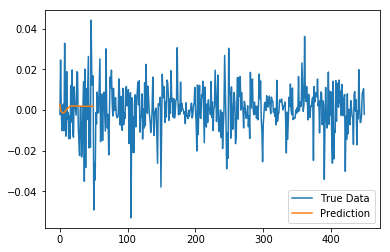

In [36]:

#Step 4 - Plot the predictions!
predictions = lstm.predict_sequences_multiple(model, x_test, 50, 50)
lstm.plot_results_multiple(predictions, y_test, 50)